# Data Fetching

Fetching historical interest rate data from FRED and implied volatility data through Alpaca.

FRED gives latest observations with a 2 day delay (on 10th September, the latest observation is 8th Spetember)

## Par Yields accross maturities (CMT), historical

/var/folders/vp/_rbg5t1d64x0b6qgzt5hqx0m0000gn/T/ipykernel_46259/1007371104.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yields = fetch_cmt_yields("2010-01-01").fillna(method="ffill")


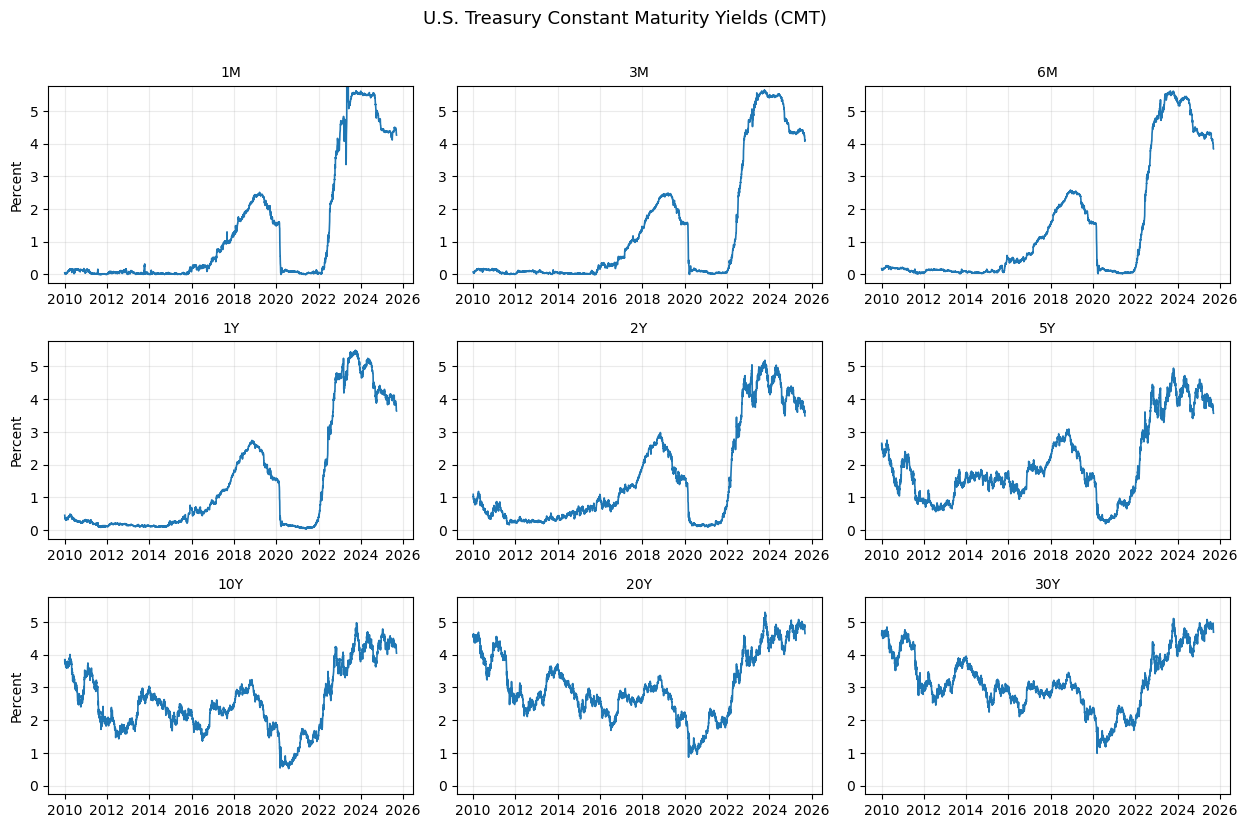

In [4]:
# You need to install this in terminal:
# pip install fredapi pandas matplotlib

from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# This is my FRED API key, the documentation is at: https://fred.stlouisfed.org/docs/api/fred/#General_Documentation 
FRED_API_KEY = "f887507374b463ac1fcc8e0ad01cbed3"
fred = Fred(api_key=FRED_API_KEY)

# --- FRED series codes (CMT = par yields, in PERCENT) ---
CODES = {
    "1m":  "DGS1MO",
    "3m":  "DGS3MO",
    "6m":  "DGS6MO",
    "1y":  "DGS1",
    "2y":  "DGS2",
    "5y":  "DGS5",
    "10y": "DGS10",
    "20y": "DGS20",
    "30y": "DGS30",
}

# --- Fetch historical par yields (CMT) ---
def fetch_cmt_yields(start="2010-01-01", end=None):
    if end is None:
        end = date.today().isoformat()
    frames = {tenor: fred.get_series(code, observation_start=start, observation_end=end)
              for tenor, code in CODES.items()}
    df = pd.concat(frames, axis=1).sort_index()
    df.index.name = "date"
    return df.astype(float)  # FRED returns percent (e.g., 4.25)

# Historical panel (in percent)
yields = fetch_cmt_yields("2010-01-01").fillna(method="ffill")

# --- Mosaic Plot of historical par yields ---
def plot_yield_mosaic(df, order=None, cols_per_row=3, title="U.S. Treasury Constant Maturity Yields (CMT)"):
    """
    df: DataFrame with columns per tenor in PERCENT (e.g., 4.25)
    order: list of column names to control panel layout
    """
    if order is None:
        order = ["1m","3m","6m","1y","2y","5y","10y","20y","30y"]
    data = df[order].copy()

    n = len(order)
    rows = int(np.ceil(n / cols_per_row))
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*4.2, rows*2.8), squeeze=False)

    # set consistent y-limits across panels (robust to outliers)
    lo = np.nanpercentile(data.values, 1)
    hi = np.nanpercentile(data.values, 99)
    pad = max(0.25, 0.05*(hi-lo))
    y_min, y_max = lo - pad, hi + pad

    for i, col in enumerate(order):
        r, c = divmod(i, cols_per_row)
        ax = axes[r, c]
        ax.plot(data.index, data[col], linewidth=1.2)
        ax.set_title(col.upper(), fontsize=10)
        ax.set_ylim(y_min, y_max)
        ax.grid(alpha=0.25)
        if r == rows-1:
            ax.set_xlabel("")  # suppress crowded x-labels on bottom row only
        if c == 0:
            ax.set_ylabel("Percent")

    # hide unused axes
    for j in range(n, rows*cols_per_row):
        r, c = divmod(j, cols_per_row)
        axes[r, c].axis("off")

    fig.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Plot historical mosaic
plot_yield_mosaic(yields)



In [5]:
print("=== HEAD ===")
print(yields.head())
print("\n=== TAIL ===")
print(yields.tail())

=== HEAD ===
              1m    3m    6m    1y    2y    5y   10y   20y   30y
date                                                            
2010-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2010-01-04  0.05  0.08  0.18  0.45  1.09  2.65  3.85  4.60  4.65
2010-01-05  0.03  0.07  0.17  0.41  1.01  2.56  3.77  4.54  4.59
2010-01-06  0.03  0.06  0.15  0.40  1.01  2.60  3.85  4.63  4.70
2010-01-07  0.02  0.05  0.16  0.40  1.03  2.62  3.85  4.62  4.69

=== TAIL ===
              1m    3m    6m    1y    2y    5y   10y   20y   30y
date                                                            
2025-09-02  4.40  4.20  3.99  3.82  3.66  3.74  4.28  4.92  4.97
2025-09-03  4.35  4.18  3.96  3.77  3.61  3.69  4.22  4.85  4.90
2025-09-04  4.33  4.16  3.94  3.76  3.59  3.65  4.17  4.81  4.86
2025-09-05  4.29  4.07  3.85  3.65  3.51  3.59  4.10  4.72  4.78
2025-09-08  4.26  4.10  3.84  3.64  3.49  3.57  4.05  4.65  4.69


## Bootstrapping to get zero cupon yields
We might need to create zero cupon series form the CMT par-yield curve:
 **ZC**: the yield that applies to a single cash flow at a specific maturity, assuming no coupons in between. Lets you value any bond by discounting each cash flow. Also, it gen give smooth yield curve accross all maturities. 

 `zero_yields` store the zero cupon yields with smoother, **half year** steps. Keep in mind that this pannel is wider than the initial `yileds` data frame (that one has only standardized maturity dates). 


In [9]:
# --- Select one curve (in percent) for a given date (kept as you had it) ---
def select_par_curve_pct(df_percent, when, method="ffill"):
    """
    df_percent: your CMT panel (PERCENT), index=date
    when: 'YYYY-MM-DD' or Timestamp
    method: 'ffill' uses last available date <= when, 'nearest' picks closest
    """
    when = pd.to_datetime(when)
    if method == "ffill":
        row = df_percent.loc[:when].iloc[-1]
    elif method == "nearest":
        idx = df_percent.index.get_indexer([when], method="nearest")[0]
        row = df_percent.iloc[idx]
    else:
        row = df_percent.loc[when]  # exact
    return row.copy()  # still in percent

# --- Bootstrap zero yields (decimals) from par (percent) with a 6M grid ---
def bootstrap_zero_yields(par_curve_pct):
    """
    par_curve_pct: Series of par yields (PERCENT) with keys like ['1m','3m','6m','1y','2y','5y','10y','20y','30y']
    Returns: Series of zero/spot yields (DECIMALS) indexed by maturity in years:
             0.0833, 0.25, 0.5, 1.0, 1.5, 2.0, ..., up to max tenor in input.
    Notes:
      - Bills (1m,3m,6m) -> simple money-market.
      - >=1y Treasuries -> semiannual coupons; coupon = par yield at that maturity.
      - We first build a par-yield function on a 0.5Y grid via linear interpolation to avoid missing coupon dates.
    """
    # map tenor labels to year fractions
    label_to_t = {"1m": 1/12, "3m": 3/12, "6m": 6/12,
                  "1y": 1.0,  "2y": 2.0,  "5y": 5.0, "10y": 10.0, "20y": 20.0, "30y": 30.0}
    # available anchor points (years, percent)
    anchors = []
    for k, t in label_to_t.items():
        if k in par_curve_pct.index and pd.notna(par_curve_pct[k]):
            anchors.append((float(t), float(par_curve_pct[k])))
    anchors.sort()  # by maturity

    # build 6M grid from 0.5Y to max anchor
    max_T = anchors[-1][0]
    grid = np.arange(0.5, max_T + 0.0001, 0.5)  # 0.5, 1.0, 1.5, ...

    # linear interpolation of par yields (percent) onto the 6M grid
    T_anchor = np.array([t for t, _ in anchors])
    Y_anchor = np.array([y for _, y in anchors])
    par_grid_pct = np.interp(grid, T_anchor, Y_anchor)  # percent

    # containers
    DF = {}       # discount factors internally
    zero = {}     # output zeros (decimals)

    # 1) money market nodes (in decimals)
    for lbl, t in [("1m", 1/12), ("3m", 3/12), ("6m", 6/12)]:
        if lbl in par_curve_pct.index and pd.notna(par_curve_pct[lbl]):
            r_dec = float(par_curve_pct[lbl]) / 100.0
            DF[t] = 1.0 / (1.0 + r_dec * t)  # simple discounting
            zero[t] = r_dec

    # 2) coupon bonds on 6M grid (>= 1.0Y), semiannual coupons
    freq = 2
    for T, par_pct in zip(grid, par_grid_pct):
        if T < 1.0:
            # already handled 0.5Y via 6m bill above
            continue
        c_annual = par_pct / 100.0
        c_per = c_annual / freq
        N = int(round(T * freq))

        # PV of coupons before maturity using existing DFs at 0.5,1.0,1.5,...,T-0.5
        pv_cpn = 0.0
        for i in range(1, N):
            ti = i / freq
            # ensure DF[ti] exists: it will, because we proceed in 0.5Y steps
            if ti not in DF:
                # if 0.5Y DF missing (e.g., no 6m bill given), approximate using nearest known DF
                # linear on time in DF-space
                known = sorted(DF.keys())
                lo = max([x for x in known if x < ti], default=None)
                hi = min([x for x in known if x > ti], default=None)
                if lo is not None and hi is not None:
                    w = (ti - lo) / (hi - lo)
                    DF[ti] = (1 - w) * DF[lo] + w * DF[hi]
                else:
                    DF[ti] = DF.get(lo, DF.get(hi))  # last resort fallback
            pv_cpn += c_per * DF[ti]

        # price at par (1.0) -> solve for DF at T
        DF_T = (1.0 - pv_cpn) / (1.0 + c_per)
        DF[T] = DF_T

        # zero (annual effective): DF = (1+z)^(-T) -> z = DF^(-1/T) - 1
        z_T = DF_T ** (-1.0 / T) - 1.0
        zero[T] = z_T

    # assemble result as a Series ordered by maturity
    out_times = sorted(zero.keys())
    out = pd.Series([zero[t] for t in out_times], index=out_times, name="zero_yield")
    return out

# --- Example usage with your existing 'yields' (PERCENT) ---
par_curve_pct = select_par_curve_pct(yields, when="2025-09-05", method="ffill")
zero_yields = bootstrap_zero_yields(par_curve_pct)

print(zero_yields.head(10))
print(zero_yields.tail())


0.083333    0.042900
0.250000    0.040700
0.500000    0.038500
1.000000    0.036814
1.500000    0.036095
2.000000    0.035371
2.500000    0.035519
3.000000    0.035665
3.500000    0.035810
4.000000    0.035955
Name: zero_yield, dtype: float64
28.0    0.050723
28.5    0.050750
29.0    0.050778
29.5    0.050809
30.0    0.050841
Name: zero_yield, dtype: float64


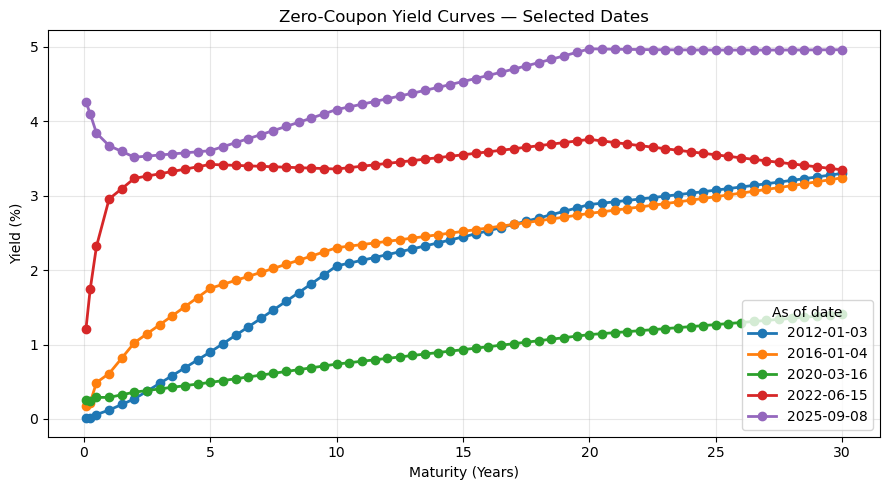

In [11]:
# --- Pick 5 dates for yield curve snapshots ---
# most recent + 4 historical points
dates_to_plot = [
    "2012-01-03",
    "2016-01-04",
    "2020-03-16",
    "2022-06-15",
    yields.index.max()   # most recent available
]

# --- Plot zero-coupon curves for selected dates ---
plt.figure(figsize=(9, 5))

for d in dates_to_plot:
    par_curve_pct = select_par_curve_pct(yields, when=d, method="ffill")
    zero_yields = bootstrap_zero_yields(par_curve_pct)
    plt.plot(zero_yields.index, zero_yields.values * 100,
             marker='o', linewidth=2,
             label=str(pd.to_datetime(d).date()))

plt.title("Zero-Coupon Yield Curves — Selected Dates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True, alpha=0.3)
plt.legend(title="As of date")
plt.tight_layout()
plt.show()


## Credit Spreads

Credit spreads give the risk premium on corporate-government bonds.